## Process SHMSL data
This is the version with smoothing and the K-M function

In [2]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import altair as alt
import pandas as pd
from pathlib import Path  # pathlib is seriously awesome!
import sys
import sklearn.decomposition as sld

In [3]:
raw_data=pd.read_csv('Merged Raw Data for Factor Analysis.csv') # <--Replace the folder and file names with the merge results csv file 
raw_data.columns.values

array(['ID', 'Exp_x', 'Site', 'Hole', 'Core_x', 'Type', 'Sect_x', 'A/W',
       'Top offset (cm)', 'Bottom offset (cm)', 'Sample Name', 'depth-m',
       'Top depth CSF-A (m)', 'Bottom depth CSF-A (m)',
       'Top depth CSF-B (m)', 'Bottom depth CSF-B (m)', 'Length (cm)',
       'Volume (cm3)', 'Sample type', 'Test', 'Request Code',
       'Request number', 'Sample name', 'Text ID', 'Date sample logged',
       'Sample entered by', 'Location', 'Comments', 'Label identifier',
       'Exp_y', 'Core_y', 'Sect_y', 'X', 'Y', 'Z', 'L', '*a', '*b', 'Hue',
       'Chroma', 'sensor_temp(C)', 'dark_pixel', 'data_type',
       'bin_interval(nm)', 'start_wavelength', 'end_wavelength',
       'time(us)', '400', '402', '404', '406', '408', '410', '412', '414',
       '416', '418', '420', '422', '424', '426', '428', '430', '432',
       '434', '436', '438', '440', '442', '444', '446', '448', '450',
       '452', '454', '456', '458', '460', '462', '464', '466', '468',
       '470', '472', '474', '476

In [4]:
v=raw_data.columns.values

In [5]:
raw_data['site_hole']=raw_data.Site+raw_data.Hole
print(raw_data.site_hole.unique())
site_holes=raw_data.site_hole.unique()
first_derivatives=dict(zip(raw_data.site_hole.unique(),np.zeros(raw_data.site_hole.unique().shape)))
km_first_derivatives=dict(zip(raw_data.site_hole.unique(),np.zeros(raw_data.site_hole.unique().shape)))

['U1449A' 'U1450A' 'U1451B' 'U1452B' 'U1453A' 'U1454B']


In [6]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def first_derivative_smooth(reflectance,wavelength,wl=5,filter='flat'):
    first=int((wl-1)/2)
    smoothed_reflectance = smooth(reflectance,wl,filter)[first:-first]
    return pd.Series(data=np.gradient(smoothed_reflectance,wavelength),index=wavelength)

def first_derivative(reflectance,wavelength):
    return pd.Series(data=np.gradient(reflectance,wavelength),index=wavelength)


In [7]:
smooth_param=99
def kubelka_munk(x):
    x = x/100
    return ((1-x)**2)/(2*x)

data_columns=['depth-m']+[str(x) for x in np.linspace(400,850,num=226,dtype='int')]

for sh in site_holes:
    print('Working on: ',sh)
    sh_data=raw_data.loc[(raw_data.site_hole==sh),[(x in data_columns) for x in raw_data.columns]]
    sh_kubelka_munk=sh_data
    sh_kubelka_munk.loc[:,'400':'850']=sh_data.loc[:,'400':'850'].applymap(kubelka_munk)
    wavelength=[float(i) for i in sh_data.drop('depth-m',axis=1).columns]
    sh_grad_smooth=sh_data.drop('depth-m',axis=1).apply(first_derivative_smooth,axis=1,raw=True,wavelength=wavelength,wl=smooth_param)
    sh_grad_smooth['depth-m']=sh_data['depth-m']
    first_derivatives[sh]=sh_grad_smooth
    
    sh_grad_km_smooth=sh_kubelka_munk.drop('depth-m',axis=1).apply(first_derivative_smooth,axis=1,raw=True,wavelength=wavelength,wl=smooth_param)
    sh_grad_km_smooth['depth-m']=sh_kubelka_munk['depth-m']
    km_first_derivatives[sh]=sh_grad_km_smooth
   
print('Finished.')
print(km_first_derivatives)

Working on:  U1449A


Working on:  U1450A
Working on:  U1451B
Working on:  U1452B
Working on:  U1453A
Working on:  U1454B
Finished.
{'U1449A':          400       402       404       406       408       410       412  \
0  -0.000199 -0.000212 -0.000452 -0.000726 -0.000823 -0.001150 -0.001384   
1  -0.000702 -0.000670 -0.000747 -0.000824 -0.001014 -0.001612 -0.002076   
2  -0.000467 -0.000427 -0.000488 -0.000481 -0.000611 -0.001023 -0.001078   
3  -0.000345 -0.000164 -0.000192 -0.000430 -0.000505 -0.000729 -0.000834   
4  -0.000345 -0.000164 -0.000192 -0.000430 -0.000505 -0.000729 -0.000834   
5  -0.000345 -0.000164 -0.000192 -0.000430 -0.000505 -0.000729 -0.000834   
6  -0.000345 -0.000164 -0.000192 -0.000430 -0.000505 -0.000729 -0.000834   
7  -0.000550 -0.000340 -0.000224 -0.000188 -0.000166 -0.000468 -0.000683   
8  -0.000688 -0.000424 -0.000272 -0.000256 -0.000371 -0.000765 -0.000819   
9  -0.000636 -0.000322 -0.000154 -0.000167 -0.000262 -0.000729 -0.001015   
10 -0.000100 -0.000155 -0.000313 -0.000482 

In [8]:
km_first_derivatives_df=pd.DataFrame.from_dict({(x,y):km_first_derivatives[x][y]
                                                for x in km_first_derivatives.keys()
                                                for y in km_first_derivatives[x].keys()},
                                            orient='columns')
km_first_derivatives_df=km_first_derivatives_df.stack(level=0)
km_first_derivatives_df=km_first_derivatives_df.droplevel(0)
km_first_derivatives_df=km_first_derivatives_df.drop_duplicates()
site_info=km_first_derivatives_df['depth-m'].reset_index()
#takes index and depth into new data frame and makes them columns
site_info=site_info.rename(columns={'index':'site'})
site_info['label']=site_info['site']+'-'+site_info['depth-m'].astype('str')
#adds new column and assigns to data from site_info (astype- convert to string)
site_info.reset_index(inplace=True)

km_first_derivatives_df=km_first_derivatives_df.drop(('depth-m'),axis=1)
min_value=km_first_derivatives_df.values.min(axis=None)
km_first_derivatives_shifted=km_first_derivatives_df-min_value
print(km_first_derivatives_shifted.shape)
print(site_info.shape)

(53, 226)
(53, 4)


In [9]:
print(km_first_derivatives_shifted)

             400       402       404       406       408       410       412  \
U1449A  0.023512  0.023499  0.023260  0.022985  0.022888  0.022561  0.022327   
U1449A  0.023009  0.023041  0.022964  0.022887  0.022697  0.022099  0.021635   
U1449A  0.023245  0.023285  0.023224  0.023230  0.023100  0.022688  0.022633   
U1449A  0.023366  0.023547  0.023520  0.023281  0.023206  0.022982  0.022877   
U1449A  0.023161  0.023371  0.023487  0.023524  0.023546  0.023243  0.023029   
U1449A  0.023023  0.023287  0.023439  0.023455  0.023341  0.022946  0.022892   
U1449A  0.023076  0.023390  0.023557  0.023544  0.023450  0.022982  0.022696   
U1449A  0.023611  0.023556  0.023398  0.023229  0.023096  0.023071  0.022913   
U1449A  0.023891  0.023824  0.023659  0.023544  0.023303  0.023115  0.023117   
U1449A  0.023467  0.023660  0.023598  0.023525  0.023539  0.023100  0.022886   
U1449A  0.023344  0.023469  0.023587  0.023689  0.023480  0.023127  0.023075   
U1450A  0.023460  0.023398  0.023287  0.

In [10]:
u1450a_first_derivative=first_derivatives['U1450A'].melt(id_vars=['depth-m'])
u1451b_first_derivative=first_derivatives['U1451B'].melt(id_vars=['depth-m'])
u1450a_km_first_derivative=km_first_derivatives['U1450A'].melt(id_vars=['depth-m'])
u1451b_km_first_derivative=km_first_derivatives['U1451B'].melt(id_vars=['depth-m'])

u1450a_first_derivative.columns=['depth','wavelength','value']
u1451b_first_derivative.columns=['depth','wavelength','value']
u1450a_km_first_derivative.columns=['depth','wavelength','value']
u1451b_km_first_derivative.columns=['depth','wavelength','value']

u1450a_first_derivative['wavelength']=pd.to_numeric(u1450a_first_derivative['wavelength'])
u1450a_first_derivative['depth']=pd.to_numeric(u1450a_first_derivative['depth'])
u1451b_first_derivative['wavelength']=pd.to_numeric(u1451b_first_derivative['wavelength'])
u1451b_first_derivative['depth']=pd.to_numeric(u1451b_first_derivative['depth'])
u1450a_km_first_derivative['wavelength']=pd.to_numeric(u1450a_km_first_derivative['wavelength'])
u1450a_km_first_derivative['depth']=pd.to_numeric(u1450a_km_first_derivative['depth'])
u1451b_km_first_derivative['wavelength']=pd.to_numeric(u1451b_km_first_derivative['wavelength'])
u1451b_km_first_derivative['depth']=pd.to_numeric(u1451b_km_first_derivative['depth'])

In [11]:
print(first_derivatives['U1450A'].index)


Int64Index([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 46, 47,
            48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
            65, 66, 67, 68],
           dtype='int64')


Working on:  U1449A
Working on:  U1450A
Working on:  U1451B
Working on:  U1452B
Working on:  U1453A
Working on:  U1454B


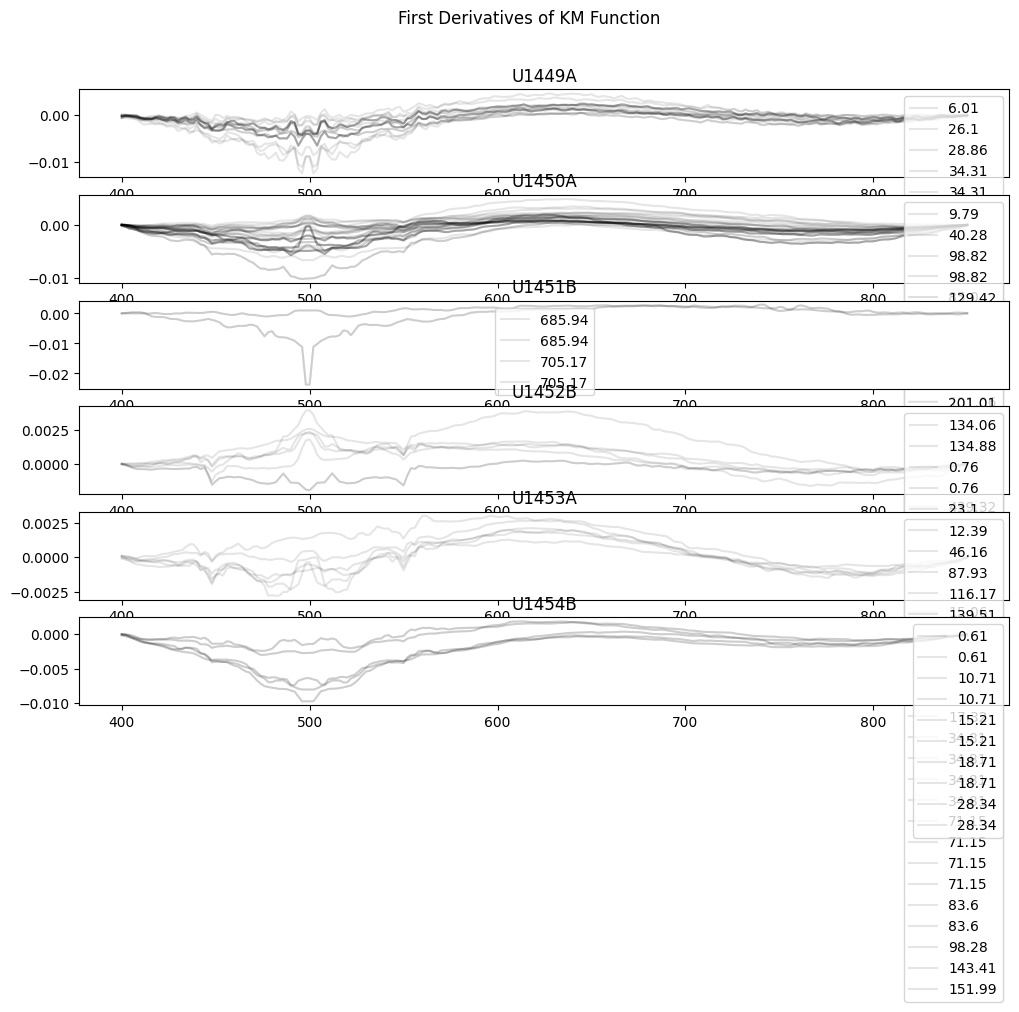

In [12]:
import matplotlib.pyplot as plt
#%matplotlib notebook

fig, ax = plt.subplots(len(site_holes), 1, figsize=(12,8), dpi=100)
fig.suptitle('First Derivatives of KM Function')

for i,sh in enumerate(site_holes):
    print('Working on: ',sh)
    km_first_derivatives[sh].T.rename(columns=km_first_derivatives[sh].T.loc['depth-m',:]).drop(index='depth-m').plot(color='k',alpha=0.1,ax=ax[i])
    ax[i].set_title(sh)
plt.show()


In [13]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [20]:
model=sld.NMF(n_components=5,init='nndsvda', solver='cd', max_iter=5000, random_state=0)
W_2 = model.fit_transform(km_first_derivatives_shifted) # Model loadings, Data 1 (unrotated)
H_2 = model.components_ # Model factors, Data 1 (unrotated)

model_loadings_2=pd.DataFrame(W_2,columns=['A','B','C','D','E']).div(pd.DataFrame(W_2,columns=['A','B','C','D','E']).sum(axis=1),axis=0)
model_factors_2=pd.DataFrame(np.transpose(H_2),columns=['A','B','C','D','E'],index=wavelength)

model_loadings_2_m=model_loadings_2.reset_index().melt(id_vars='index')
model_factors_2_m=model_factors_2.reset_index().melt(id_vars='index')


model_loadings_2_m=pd.merge(site_info, model_loadings_2_m,on='index')

model_loadings_2_chart=alt.Chart(model_loadings_2_m).mark_bar().encode(
    x='depth-m:Q',
    y='value:Q',
    facet='site:N',
    color='variable:N',
    tooltip='depth-m'
).properties(
    height=300,
    width=900,
    title='Model 1 (unrotated)'
)
display(model_loadings_2_chart)

model_2_factors_chart=alt.Chart(model_factors_2_m).mark_line(strokeDash=[1,1]).encode(
    x=alt.X('index:Q',title='wavelength',scale=alt.Scale(domain=(400,850))),
    y='value:Q',
    color='variable:N'
).properties(
    width=600,
    height=300,
    title='Model 1 (unrotated)'
)
display( (model_2_factors_chart))

model_2_error=km_first_derivatives_shifted-model.inverse_transform(W_2)
model_2_error_m=pd.DataFrame(model_2_error).reset_index().melt(id_vars='index')

error_squared=np.square(model_2_error)
error_squared_mean=error_squared.stack().mean()
print(error_squared_mean)


model_2_error_chart=alt.Chart(model_2_error_m).mark_line(opacity=0.5,color='black').encode(
    x='variable:Q',
    y='value:Q',
    detail='index:O'
).properties(
    title='Model 1 Error',
    width=600,
    height=300
)
display(model_2_error_chart)


alt.Chart(...)

alt.Chart(...)

3.041346926718297e-08


alt.Chart(...)

In [ ]:
model=sld.NMF(n_components=3,init='nndsvda', solver='cd', max_iter=5000, random_state=0)
W_1 = model.fit_transform(km_first_derivatives_shifted) # Model loadings, Data 1 (unrotated)
H_1 = model.components_ # Model factors, Data 1 (unrotated)

model_loadings_1=pd.DataFrame(W_1,columns=['A','B','C']).div(pd.DataFrame(W_1,columns=['A','B','C']).sum(axis=1),axis=0)
model_factors_1=pd.DataFrame(np.transpose(H_1),columns=['A','B','C'],index=wavelength)

model_loadings_1_m=model_loadings_1.reset_index().melt(id_vars='index')
model_factors_1_m=model_factors_1.reset_index().melt(id_vars='index')


model_loadings_1_m=pd.merge(site_info, model_loadings_1_m,on='index')
print(model_loadings_1_m)

model_loadings_1_chart=alt.Chart(model_loadings_1_m).mark_bar().encode(
    x='depth-m:Q',
    y='value:Q',
    facet='site:N',
    color='variable:N',
    tooltip='depth-m'
).properties(
    height=300,
    width=900,
    title='Model 1 (unrotated)'
)
display(model_loadings_1_chart)

model_1_factors_chart=alt.Chart(model_factors_1_m).mark_line(strokeDash=[1,1]).encode(
    x=alt.X('index:Q',title='wavelength',scale=alt.Scale(domain=(400,850))),
    y='value:Q',
    color='variable:N'
).properties(
    width=600,
    height=300,
    title='Model 1 (unrotated)'
)
display( (model_1_factors_chart))

model_1_error=km_first_derivatives_shifted-model.inverse_transform(W_1)
model_1_error_m=pd.DataFrame(model_1_error).reset_index().melt(id_vars='index')
model_1_error_chart=alt.Chart(model_1_error_m).mark_line(opacity=0.5,color='black').encode(
    x='variable:Q',
    y='value:Q',
    detail='index:O'
).properties(
    title='Model 1 Error',
    width=600,
    height=300
)
display(model_1_error_chart)


     index    site  depth-m         label variable     value
0        0  U1449A     6.01   U1449A-6.01        A  0.646046
1        0  U1449A     6.01   U1449A-6.01        B  0.041393
2        0  U1449A     6.01   U1449A-6.01        C  0.312561
3        1  U1449A    26.10   U1449A-26.1        A  0.645304
4        1  U1449A    26.10   U1449A-26.1        B  0.018529
..     ...     ...      ...           ...      ...       ...
154     51  U1454B    18.71  U1454B-18.71        B  0.139521
155     51  U1454B    18.71  U1454B-18.71        C  0.233824
156     52  U1454B    28.34  U1454B-28.34        A  0.676300
157     52  U1454B    28.34  U1454B-28.34        B  0.176020
158     52  U1454B    28.34  U1454B-28.34        C  0.147681

[159 rows x 6 columns]


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [22]:
model=sld.NMF(n_components=3,init='nndsvda', solver='cd', max_iter=5000, random_state=0)
W_1 = model.fit_transform(km_first_derivatives_shifted) # Model loadings, Data 1 (unrotated)
H_1 = model.components_ # Model factors, Data 1 (unrotated)

model_loadings_1=pd.DataFrame(W_1,columns=['A','B','C']).div(pd.DataFrame(W_1,columns=['A','B','C']).sum(axis=1),axis=0)
model_factors_1=pd.DataFrame(np.transpose(H_1),columns=['A','B','C'],index=wavelength)

model_loadings_1_m=model_loadings_1.reset_index().melt(id_vars='index')
model_factors_1_m=model_factors_1.reset_index().melt(id_vars='index')


model_loadings_1_m=pd.merge(site_info, model_loadings_1_m,on='index')
print(model_loadings_1_m)

model_loadings_1_chart=alt.Chart(model_loadings_1_m).mark_bar().encode(
    x='depth-m:Q',
    y='value:Q',
    facet='site:N',
    color='variable:N',
    tooltip='depth-m'
).properties(
    height=300,
    width=900,
    title='Model 1 (unrotated)'
)
display(model_loadings_1_chart)

model_1_factors_chart=alt.Chart(model_factors_1_m).mark_line(strokeDash=[1,1]).encode(
    x=alt.X('index:Q',title='wavelength',scale=alt.Scale(domain=(400,850))),
    y='value:Q',
    color='variable:N'
).properties(
    width=600,
    height=300,
    title='Model 1 (unrotated)'
)
display( (model_1_factors_chart))

model_1_error=km_first_derivatives_shifted-model.inverse_transform(W_1)
model_1_error_m=pd.DataFrame(model_1_error).reset_index().melt(id_vars='index')
model_1_error_chart=alt.Chart(model_1_error_m).mark_line(opacity=0.5,color='black').encode(
    x='variable:Q',
    y='value:Q',
    detail='index:O'
).properties(
    title='Model 1 Error',
    width=600,
    height=300
)
display(model_1_error_chart)


     index    site  depth-m         label variable     value
0        0  U1449A     6.01   U1449A-6.01        A  0.646046
1        0  U1449A     6.01   U1449A-6.01        B  0.041393
2        0  U1449A     6.01   U1449A-6.01        C  0.312561
3        1  U1449A    26.10   U1449A-26.1        A  0.645304
4        1  U1449A    26.10   U1449A-26.1        B  0.018529
..     ...     ...      ...           ...      ...       ...
154     51  U1454B    18.71  U1454B-18.71        B  0.139521
155     51  U1454B    18.71  U1454B-18.71        C  0.233824
156     52  U1454B    28.34  U1454B-28.34        A  0.676300
157     52  U1454B    28.34  U1454B-28.34        B  0.176020
158     52  U1454B    28.34  U1454B-28.34        C  0.147681

[159 rows x 6 columns]


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [40]:
model_loadings_2_m.to_csv('model loadings merge check',index=False)

The following are extra bits of code I kept around for future reference

In [ ]:
import altair as alt
alt.data_transformers.disable_max_rows()

u1450a_chart=alt.Chart(u1450a_first_derivative).mark_line(opacity=0.1).encode(
    x=alt.X('wavelength:Q'),
    y=alt.Y('value:Q'),
    color='depth:Q'
)

display (u1450a_chart)

In [ ]:
def kubelka_munk(x):
    x = x/100
    return ((1-x)**2)/(2*x)

km_transformed = raw_data.applymap(kubelka_munk)
km_transformed['wavelength']=raw_data['wavelength']
print(km_transformed.head())

In [ ]:
km_200=alt.Chart(km_transformed.loc[:,['wavelength',100,1,0.1,0]].melt(id_vars=['wavelength'])).mark_line().encode(
    x=alt.X('wavelength'),
    y=alt.Y('value',axis=alt.Axis(title='K-M function')),
    color='variable'
)
display(km_200|raw_200)

In [ ]:
smooth_param=99
grad_raw=raw_data.drop('wavelength',axis=1).apply(first_derivative,axis=0,raw=True,wavelength=raw_data['wavelength'].values)
grad_raw['wavelength']=raw_data['wavelength']
grad_raw_smooth=raw_data.drop('wavelength',axis=1).apply(first_derivative_smooth,axis=0,raw=True,wavelength=raw_data['wavelength'].values,wl=smooth_param)
grad_raw_smooth['wavelength']=raw_data['wavelength']
grad_km=km_transformed.drop('wavelength',axis=1).apply(first_derivative,axis=0,raw=True,wavelength=km_transformed['wavelength'].values)
grad_km['wavelength']=km_transformed['wavelength']
grad_km_smooth=km_transformed.drop('wavelength',axis=1).apply(first_derivative_smooth,axis=0,raw=True,wavelength=km_transformed['wavelength'].values,wl=smooth_param)
grad_km_smooth['wavelength']=km_transformed['wavelength']


In [ ]:
grad_raw_200=alt.Chart(grad_raw.loc[:,['wavelength',100,1,0.1,0]].melt(id_vars=['wavelength'])).mark_line().encode(
    x=alt.X('wavelength'),
    y=alt.Y('value',axis=alt.Axis(title='d/dl % Reflectance')),
    color=alt.Color('variable',scale=alt.Scale(scheme='blues'))
)

grad_km_200=alt.Chart(grad_km.loc[:,['wavelength',100,1,0.1,0]].melt(id_vars=['wavelength'])).mark_line().encode(
    x=alt.X('wavelength'),
    y=alt.Y('value',axis=alt.Axis(title='d/dl K-M function')),
    color=alt.Color('variable',scale=alt.Scale(scheme='blues'))
)
grad_raw_s_200=alt.Chart(grad_raw_smooth.loc[:,['wavelength',100,1,0.1,0]].melt(id_vars=['wavelength'])).mark_line().encode(
    x=alt.X('wavelength'),
    y=alt.Y('value',axis=alt.Axis(title='d/dl % Reflectance')),
    color=alt.Color('variable',scale=alt.Scale(scheme='reds'))
)

grad_km_s_200=alt.Chart(grad_km_smooth.loc[:,['wavelength',100,1,0.1,0]].melt(id_vars=['wavelength'])).mark_line().encode(
    x=alt.X('wavelength'),
    y=alt.Y('value',axis=alt.Axis(title='d/dl K-M function')),
    color=alt.Color('variable',scale=alt.Scale(scheme='reds'))
)
display(((grad_km_s_200)|(grad_raw_s_200))
        & 
       (km_200|raw_200))

In [ ]:
def peaks(x,wavelength, smooth_param_peaks=smooth_param):
    p,_=sig.find_peaks(-x,width=smooth_param_peaks)
    if p.size >0:
        x0 = x[p].item()
        wavelength0 = wavelength[p].item()
    else:
        x0 = np.nan
        wavelength0 = np.nan
    return [x0,wavelength0]

grad_km_peaks=pd.DataFrame(columns=['peak','wavelength'],index=grad_km_smooth.drop('wavelength',axis=1).columns)
grad_km_peaks[['peak','wavelength']]=pd.Series(grad_km_smooth.drop('wavelength',axis=1).apply(peaks,axis=0,wavelength=grad_km_smooth['wavelength'],raw=True,result_type='expand')).tolist()
print(grad_km_peaks)


In [ ]:
transfer_function=alt.Chart(grad_km_peaks.reset_index()).mark_point().encode(
    x='index',
    y='peak'
)
transfer_regression=alt.Chart(grad_km_peaks[grad_km_peaks.index>=1].reset_index()).encode(
    x='index',
    y='peak'
).transform_regression(on='index',regression='peak',method='log').mark_line(color='black')
display(transfer_function+transfer_regression)